In [1]:
#!pip install h5py
import h5py

In [2]:
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm

import pyfstat
from pyfstat.utils import get_sft_as_arrays

# Local module to simplify plotting
import tutorial_utils

logger = pyfstat.set_up_logger(label="my_generating_noise", log_level="INFO")

%matplotlib inline

22-11-27 04:04:13.518 pyfstat INFO    : Running PyFstat version 1.18.1+84.5ded4a67.clean
22-11-27 04:04:13.746 pyfstat.utils.importing INFO    : No $DISPLAY environment variable found, so importing matplotlib.pyplot with non-interactive 'Agg' backend.


In [3]:
# ================================================
# 生成したhdf5ファイルロードできるか確認
# ================================================
import h5py
from pathlib import Path

def load_hdf5(h_path):
    """hdf5ファイルロード"""
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]

        # [:]を最後につけないと取り出せないので注意
        freq = g['frequency_Hz'][:]  # shape: (360,) 各振動数

        h1_a = g["H1"]['SFTs'][:]
        h1_t = g["H1"]['timestamps_GPS'][:]

        l1_a = g["L1"]['SFTs'][:]
        l1_t = g["L1"]['timestamps_GPS'][:]
    
    return freq, h1_a, l1_a, h1_t, l1_t

# gen_non_stationary_noise

In [16]:
def gen_non_stationary_noise(out_path, file_id, F0, min_sqrtSX=1e-24, n_segment=10):
    """非定常ノイズデータを生成してhdf5に保存する
    gapノイズ(timestamps)は非定常のsegmentと併用できなかった
    """
    
    # Setup Writer
    writer_kwargs = {
        "outdir": "my_generating_noise",
        "duration": 30 * 4 * 24 * 3600,  #5 * 86400,  # 継続時間[秒］。4ヶ月
        "detectors": "H1,L1",  # シミュレーションする検出器(ここではLIGOハンフォード)
        "Tsft": 1800,  # フーリエ変換の継続時間
        "SFTWindowType": "tukey",  # 短時間フーリエ変換を計算するための窓関数
        "SFTWindowBeta": 0.01,  # 窓関数に関連するパラメータ。0.01, 0.001 どちらでも変わらんらしい(https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#2003112
        
        # 関係ないと思うが一応時刻もランダムに変えとく
        "tstart": np.random.randint(1238166018,1248724262),  # 観測開始時刻 [GPS時刻]

        # コンペデータの振動数の範囲内でバンドの中心周波数ランダムに変える
        "F0": F0,  # 生成するバンドの中心周波数 [Hz]. [F0 - Band/2, F0 + Band/2]
        "Band": 0.5,  # F0付近の周波数帯域幅 [Hz]
    }
    
    # =================================================
    # めちゃくちゃ中間ファイル作られるから実行前にきれいにする
    # =================================================
    if os.path.exists("my_generating_noise"):
        shutil.rmtree("my_generating_noise")
        os.mkdir("my_generating_noise")
    
    # =================================================
    # 非定常なノイズにするため振幅の強さランダムに変える
    # =================================================
    segment_sqrtSX = []
    for segment in range(n_segment):
        # とりあえず4倍まで変える
        r = np.random.randint(1,4+1) + np.random.rand()
        segment_sqrtSX.append( min_sqrtSX*r ) 
    
    # =================================================
    # 継続時間[秒］変更するduration
    # =================================================
    duration_MAX = writer_kwargs["duration"]
    segment_idxs = sorted(np.random.choice(list(range(5760)), n_segment, replace=False)) # 5760(=4*30*24*3600/1800)タイムスタンプの最大長さ
    segment_lengths = [segment_idxs[0]*1800]
    for i in range(1, n_segment):
        segment_lengths.append( segment_idxs[i]*1800 - segment_idxs[i - 1]*1800 )  
    segment_lengths.append( duration_MAX - segment_idxs[-1]*1800 )
    #print("segment_lengths:", sum(segment_lengths)/(24 * 3600), segment_lengths)
    
    # =================================================
    # duration単位でデータ生成
    # =================================================
    sft_path = []  # リストにsftファイルを詰めて";"で連結したら1ファイルで出力可能
    for segment in range(n_segment):
        # パラメータ変更
        writer_kwargs["label"] = f"segment_{segment}"
        writer_kwargs["duration"] = segment_lengths[segment]
        writer_kwargs["sqrtSX"] = segment_sqrtSX[segment]
        
        # 観測開始時刻 [GPS時刻] をずらす
        if segment > 0:
            writer_kwargs["tstart"] += writer_kwargs["Tsft"] + segment_lengths[segment - 1]
    
        # データ生成
        writer = pyfstat.Writer(**writer_kwargs)
        writer.make_data()
        
        # sftファイルをリストに詰める
        sft_path.append(writer.sftfilepath)
    
    sft_path = ";".join(sft_path)  # ; で異なるファイルを結合
    frequency, timestamps, fourier_data = get_sft_as_arrays(sft_path)  # SFTデータをnumpyの配列に読み込み
    
    # =================================================
    # 対象の周波数帯域の 0.2 の範囲だけスライス
    # =================================================
    # https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#1987496
    first_index = np.argmin( np.abs( frequency - writer_kwargs["F0"] ) )
    last_index = np.argmin( np.abs( frequency - (writer_kwargs["F0"] + 0.2) ) )
    frequency = frequency[first_index:last_index+1]
    h1_amp = fourier_data["H1"][first_index:last_index + 1, :]
    l1_amp = fourier_data["L1"][first_index:last_index + 1, :]
    
    # 360の長さまでにしておく（361になるときがあるので）
    frequency = frequency[:360]
    h1_amp = h1_amp[:360,:]
    l1_amp = l1_amp[:360,:]
    
    # =================================================
    # HDF5ファイルの作成
    # =================================================
    print(timestamps["H1"])
    # segmentアリだと4096未満になるときあるので対策する
    if (len(timestamps["H1"]) >= 4096) and (len(timestamps["L1"]) >= 4096):
                                                           
        with h5py.File(f"{out_path}", "w") as h5:
            g = h5.create_group(str(file_id))
            g.create_dataset('frequency_Hz', data=frequency)

            g_h = g.create_group("H1")
            g_h.create_dataset('SFTs', data=h1_amp)
            g_h.create_dataset('timestamps_GPS', data=timestamps["H1"])

            g_l = g.create_group("L1")
            g_l.create_dataset('SFTs', data=l1_amp)
            g_l.create_dataset('timestamps_GPS', data=timestamps["L1"])
    
    return frequency, timestamps["H1"], timestamps["L1"], h1_amp, l1_amp

# gen_gap_noise

In [5]:
def gen_gap_noise_detectors(out_path, file_id, sqrtSX, F0, prob_gap, detectors):
    """detectors指定してgapノイズデータを生成
    gapノイズ(timestamps)は非定常の duration, tstart と併用できなかった
    """
    
    # Setup Writer
    writer_kwargs = {
        "outdir": "my_generating_noise",
        #"duration": 30 * 4 * 24 * 3600,  #5 * 86400,  # 継続時間[秒］。4ヶ月

        "detectors": detectors,  # シミュレーションする検出器(ここではLIGOハンフォード)
        
        "Tsft": 1800,  # フーリエ変換の継続時間
        "SFTWindowType": "tukey",  # 短時間フーリエ変換を計算するための窓関数
        "SFTWindowBeta": 0.01,  # 窓関数に関連するパラメータ。0.01, 0.001 どちらでも変わらんらしい(https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#2003112

        ## 関係ないと思うが一応時刻もランダムに変えとく
        #"tstart": np.random.randint(1238166018,1248724262),  # 観測開始時刻 [GPS時刻]
        
        "sqrtSX": sqrtSX,  # 雑音の片側振幅スペクトル密度
        
        # コンペデータの振動数の範囲内でバンドの中心周波数ランダムに変える
        "F0": F0,  # 生成するバンドの中心周波数 [Hz]. [F0 - Band/2, F0 + Band/2]
        "Band": 0.5,  # F0付近の周波数帯域幅 [Hz]
    }
    
    # =================================================
    # 中間ファイル作られるから実行前にきれいにする
    # =================================================
    if os.path.exists("my_generating_noise"):
        shutil.rmtree("my_generating_noise")
        os.mkdir("my_generating_noise")
    
    # =================================================
    # 各 GPS タイムスタンプのリスト。リストの要素間の飛びの時間はデータが存在しない「ギャップ」になる
    # =================================================
    max_gap_sec = (4*30 - 81) * 24 * 3600  # 取り得るgapの全時間sec。test setのデータある観測時間の最小は81日間
    #min_gap_sec = (4*30 - 101) * 24 * 3600  # 取り得るgapの全時間sec。test setのデータある観測時間の最大は101日間
    Tstart = 1238166018  # 観測開始時刻 [GPS時刻]
    gap_sum = 0
    timestamps = [Tstart]
    if detectors == "H1":
        # h1のタイムスタンプの数
        n_idxs = np.random.randint(4281, 4887+1)  # test setのタイムスタンプの数より
    else:
        # l1のタイムスタンプの数
        n_idxs = np.random.randint(4297, 4878+1)  # test setのタイムスタンプの数より
    #for idx in range(5760): # 5760(=4*30*24*3600/1800)タイムスタンプの最大長さ
    for idx in range(n_idxs):
        # prob_gapの確率でgap入れる
        if ( np.random.rand() > 1 - prob_gap ) and ( gap_sum+1 < max_gap_sec ):
            # 最低1秒gapありとした
            # https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/358835#2026499
            inteval = np.random.randint(1, 105026+1)  # test setのgapの最大は105026sec
            gap_sum += inteval
        else:
            inteval = 1800
        timestamps += [timestamps[-1] + inteval]
    #print("timestamps:", list( np.array(timestamps[1:])-np.array(timestamps[:-1]) ))
    writer_kwargs["timestamps"] = np.array(timestamps)
    
    # =================================================
    # データ生成
    # =================================================
    # Create SFTs
    writer = pyfstat.Writer(**writer_kwargs)
    writer.make_data()
    
    # SFTデータをnumpyの配列に読み込み
    frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)
    
    return frequency, timestamps, fourier_data


def gen_gap_noise(out_path, file_id, sqrtSX, F0, prob_gap=0.01):
    """gapノイズデータを生成してhdf5に保存する
    gapノイズ(timestamps)は非定常の duration, tstart と併用できなかった
    """
    
    # h1とl1で異なるgapにするためにそれぞれでデータ生成
    frequency, timestamps_h1, fourier_data_h1 = gen_gap_noise_detectors(out_path, file_id, sqrtSX, F0, prob_gap, "H1")
    frequency, timestamps_l1, fourier_data_l1 = gen_gap_noise_detectors(out_path, file_id, sqrtSX, F0, prob_gap, "L1")
    
    # =================================================
    # 対象の周波数帯域の 0.2 の範囲だけスライス
    # =================================================
    # https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#1987496
    first_index = np.argmin( np.abs( frequency - F0 ) )
    last_index = np.argmin( np.abs( frequency - (F0 + 0.2) ) )
    frequency = frequency[first_index:last_index+1]
    h1_amp = fourier_data_h1["H1"][first_index:last_index + 1, :]
    l1_amp = fourier_data_l1["L1"][first_index:last_index + 1, :]
    
    # 360の長さまでにしておく（361になるときがあるので）
    frequency = frequency[:360]
    h1_amp = h1_amp[:360,:]
    l1_amp = l1_amp[:360,:]
    
    # =================================================
    # HDF5ファイルの作成
    # =================================================
    with h5py.File(f"{out_path}", "w") as h5:
        g = h5.create_group(str(file_id))
        g.create_dataset('frequency_Hz', data=frequency)
        
        g_h = g.create_group("H1")
        g_h.create_dataset('SFTs', data=h1_amp)
        g_h.create_dataset('timestamps_GPS', data=timestamps_h1["H1"])
        
        g_l = g.create_group("L1")
        g_l.create_dataset('SFTs', data=l1_amp)
        g_l.create_dataset('timestamps_GPS', data=timestamps_l1["L1"])
    
    return frequency, timestamps_h1["H1"], timestamps_l1["L1"], h1_amp, l1_amp

# Main

In [18]:
# ================================================
# hdf5ファイル生成
# ================================================
def main(debug=True):
        
    def _gen_gap_noise(min_sqrtSX, max_sqrtSX, n_len, start_id=0):
        for i in range(n_len):
            F0 = np.random.randint(50,500) + np.random.rand()
            
            _n_max = int((max_sqrtSX - min_sqrtSX) / min_sqrtSX) + 1
            sqrtSX = np.random.randint(1,_n_max) * min_sqrtSX
            
            _sqrtSX = '{:.3g}'.format(sqrtSX)
            file_id = f"{start_id + i}_sqrtSX{_sqrtSX}_F0{str(round(F0,2))}_gap"
            out_path = f"{OUTDIR}/{file_id}.hdf5"

            frequency, h1_ts, l1_ts, h1_amp, l1_amp = gen_gap_noise(out_path, str(file_id), sqrtSX, F0)
            
    def _gen_non_stationary_noise(min_sqrtSX, max_sqrtSX, n_len, start_id=0):
        for i in tqdm(range(n_len)):
            F0 = np.random.randint(50,500) + np.random.rand()
            
            _n_max = int((max_sqrtSX - min_sqrtSX) / min_sqrtSX) + 1
            sqrtSX = np.random.randint(1,_n_max) * min_sqrtSX
            
            n_segment = np.random.randint(5,20)

            _sqrtSX = '{:.3g}'.format(sqrtSX)
            file_id = f"{start_id + i}_sqrtSX{_sqrtSX}_F0{str(round(F0,2))}_segment{n_segment}"
            out_path = f"{OUTDIR}/{file_id}.hdf5"
            #print(out_path)

            for _ in range(10):
                frequency, h1_ts, l1_ts, h1_amp, l1_amp = gen_non_stationary_noise(out_path, file_id, F0, min_sqrtSX=sqrtSX, n_segment=n_segment)
                # segmentアリだと4096未満になるときあるので対策する
                if (len(h1_ts) >= 4096) and (len(l1_ts) >= 4096):
                    break
    
    if debug:
        GAP_N_LEN = 1
        NON_STAT_N_LEN = 1
    else:
        GAP_N_LEN = 400
        NON_STAT_N_LEN = 100
    
    # 振幅の桁数変えたgap_noise
    _gen_gap_noise(5e-24, 2e-22, GAP_N_LEN, start_id=0)  # ex002の結果からtestのH1,L1はこれぐらいのオーダー感
    
    # 振幅の桁数変えたnon_stationary_noise
    _gen_non_stationary_noise(5e-24, 2e-22, NON_STAT_N_LEN, start_id=GAP_N_LEN)  # ex002の結果からtestのH1,L1はこれぐらいのオーダー感
    #_gen_non_stationary_noise(5e-24, 2e-22, 100-72, start_id=472)  # 途中で止まったから一部やり直した
    
    
if __name__ == '__main__':
    OUTDIR = "/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise"
    
    #if os.path.exists(OUTDIR):
    #    shutil.rmtree(OUTDIR)
    #os.mkdir(OUTDIR)
        
    #main(debug=True)
    main(debug=False)
    

#from IPython.display import clear_output  # セルの出力削除（ログあると重すぎるので消す)
#clear_output()

  0%|          | 0/28 [00:00<?, ?it/s]

22-11-13 13:04:50.153 pyfstat.core INFO    : Creating Writer object...
22-11-13 13:04:50.153 pyfstat.utils.ephemeris INFO    : No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.
22-11-13 13:04:50.156 pyfstat.make_sfts INFO    : Generating SFTs with fmin=172.5659662011817, Band=0.5
22-11-13 13:04:50.156 pyfstat.make_sfts INFO    : Got h0=0, not writing an injection .cff file.
22-11-13 13:04:50.157 pyfstat.make_sfts INFO    : Checking if we can re-use existing SFT data file(s)...
22-11-13 13:04:50.158 pyfstat.make_sfts INFO    : ...no SFT file matching 'my_generating_noise/H-875_H1_1800SFT_segment_0-1238441334-1575000.sft' found. Will create new SFT file(s).
22-11-13 13:04:50.159 pyfstat.utils.cli INFO    : Now executing: lalpulsar_Makefakedata_v5 --outSingleSFT=TRUE --outSFTdir="my_generating_noise" --outLabel="segment_0" --IFOs="H1

In [7]:
import pandas as pd
import glob
OUTDIR = "/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise"

_df = pd.DataFrame({"id": [Path(p).stem for p in sorted(glob.glob(f"{OUTDIR}/*.hdf5"))], "target": 0})
_df.to_csv(OUTDIR + "/df.csv", index=False)

fmins, fmaxs = [], []
h1_hsizes, h1_wsizes = [], []
l1_hsizes, l1_wsizes = [], []
h1_amp_mins, h1_amp_maxs = [], []
l1_amp_mins, l1_amp_maxs = [], []
h1_tmins, h1_tmaxs = [], []
l1_tmins, l1_tmaxs = [], []
h1_max_intevals, l1_max_intevals = [], []
for _id in tqdm( _df["id"].to_numpy() ):
    h_path = f"{OUTDIR}/{_id}.hdf5"
    file_id = Path(h_path).stem
    freq, h1_a, l1_a, h1_t, l1_t = load_hdf5(h_path)
    
    fmins.append(freq.min())
    fmaxs.append(freq.max())
    
    h1_hsizes.append(h1_a.shape[0])
    h1_wsizes.append(h1_a.shape[1])
    
    l1_hsizes.append(l1_a.shape[0])
    l1_wsizes.append(l1_a.shape[1])
    
    h1_amp_mins.append(h1_a.min())
    h1_amp_maxs.append(h1_a.max())
    
    l1_amp_mins.append(l1_a.min())
    l1_amp_maxs.append(l1_a.max())

    h1_tmins.append(h1_t.min())
    h1_tmaxs.append(h1_t.max())
    
    l1_tmins.append(l1_t.min())
    l1_tmaxs.append(l1_t.max())
    
    h1_max_inteval = np.max(h1_t[1:]-h1_t[0:-1])
    l1_max_inteval = np.max(l1_t[1:]-l1_t[0:-1])
    h1_max_intevals.append(h1_max_inteval)
    l1_max_intevals.append(l1_max_inteval)

_df["freq min"] = fmins
_df["freq max"] = fmaxs
_df["H1 SFTs h"] = h1_hsizes
_df["H1 SFTs w"] = h1_wsizes
_df["H1 time min"] = h1_tmins
_df["H1 time max"] = h1_tmaxs
_df["H1 max inteval"] = h1_max_intevals
_df["L1 SFTs h"] = l1_hsizes
_df["L1 SFTs w"] = l1_wsizes
_df["L1 time min"] = l1_tmins
_df["L1 time max"] = l1_tmaxs
_df["L1 max inteval"] = l1_max_intevals
_df["freq_min//10"] = _df["freq min"]//10
_df["freq_min//10_target"] = _df["freq_min//10"].astype(str) + "_" + _df["target"].astype(str)
    
_df.to_csv(OUTDIR + "/df_summary.csv", index=False)
_df

  0%|          | 0/500 [00:00<?, ?it/s]

id  target    freq min    freq max  \
0       0_sqrtSX3.5e-23_F078.32_gap       0   78.316111   78.515556   
1      100_sqrtSX4e-23_F0337.34_gap       0  337.343889  337.543333   
2    101_sqrtSX1.8e-22_F0437.06_gap       0  437.058889  437.258333   
3    102_sqrtSX5.5e-23_F0121.62_gap       0  121.617222  121.816667   
4       103_sqrtSX1e-22_F0418.1_gap       0  418.095556  418.295000   
..                              ...     ...         ...         ...   
495  96_sqrtSX1.25e-22_F0438.12_gap       0  438.118889  438.318333   
496   97_sqrtSX3.5e-23_F0301.99_gap       0  301.987778  302.187222   
497   98_sqrtSX1.8e-22_F0360.61_gap       0  360.608333  360.807778   
498   99_sqrtSX8.5e-23_F0467.21_gap       0  467.208333  467.407778   
499    9_sqrtSX1.8e-22_F0102.71_gap       0  102.710556  102.910000   

     H1 SFTs h  H1 SFTs w  H1 time min  H1 time max  H1 max inteval  \
0          360       4638   1238166018   1248876636          102173   
1          360       4790   1238166018   1249217402          104189   
2          360       4777   1238166018   1249045227          104919   
3          360       4301   1238166018   1248523942          104419   
4          360       4420   1238166018   1248228032          102720   
..         ...        ...          ...          ...             ...   
495        360       4877   1238166018   1249111408          104594   
496        360       4486   1238166018   1249099233          104457   
497        360       4381   1238166018   1248115649           96315   
498        360       4631   1238166018   1248629717          102402   
499        360       4868   1238166018   1249541291          104296   

     L1 SFTs h  L1 SFTs w  L1 time min  L1 time max  L1 max inteval  \
0          360       4854   1238166018   1249037209          103825   
1          360       4318   1238166018   1247414921          102609   
2          360       4324   1238166018   1248508142          101842   
3          360       4498   1238166018   1247888351          102421   
4          360       4535   1238166018   1248455700          101956   
..         ...        ...          ...          ...             ...   
495        360       4549   1238166018   1248752434          104470   
496        360       4790   1238166018   1248729067          102093   
497        360       4667   1238166018   1249541686           97179   
498        360       4426   1238166018   1248763645          102404   
499        360       4474   1238166018   1249148743           98321   

     freq_min//10 freq_min//10_target  
0             7.0               7.0_0  
1            33.0              33.0_0  
2            43.0              43.0_0  
3            12.0              12.0_0  
4            41.0              41.0_0  
..            ...                 ...  
495          43.0              43.0_0  
496          30.0              30.0_0  
497          36.0              36.0_0  
498          46.0              46.0_0  
499          10.0              10.0_0  

[500 rows x 16 columns]

# Check

In [7]:
import glob
OUTDIR = "/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise"

(360,)
(360, 4638) (360, 4854)
(4638,) (4854,)
h1 sum gap: 27.36 days
l1 sum gap: 24.72 days


(<Figure size 1600x1000 with 4 Axes>,
 array([<AxesSubplot: title={'center': 'SFT Real part'}, xlabel='SFT index', ylabel='Frequency [Hz]'>,
        <AxesSubplot: title={'center': 'SFT Imaginary part'}, xlabel='SFT index', ylabel='Frequency [Hz]'>],
       dtype=object))

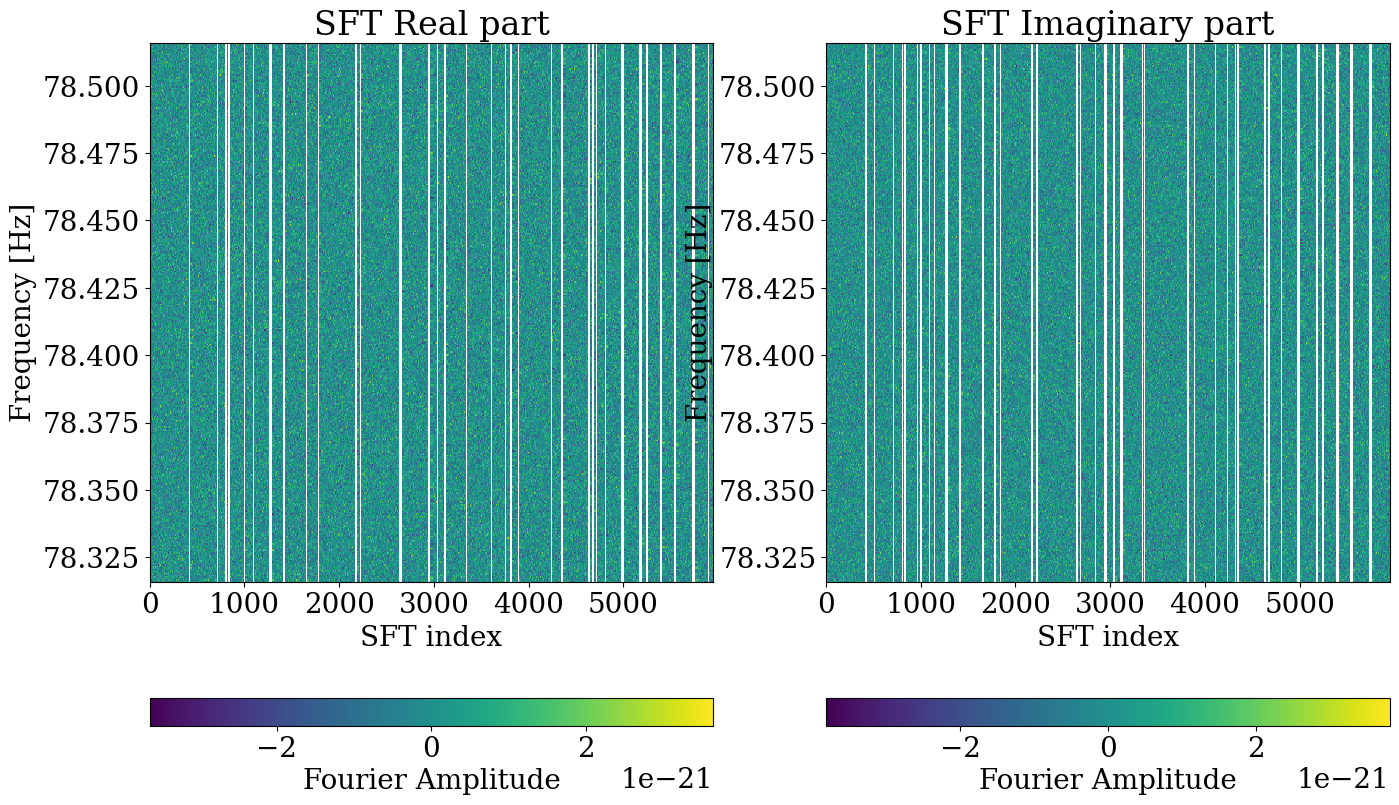

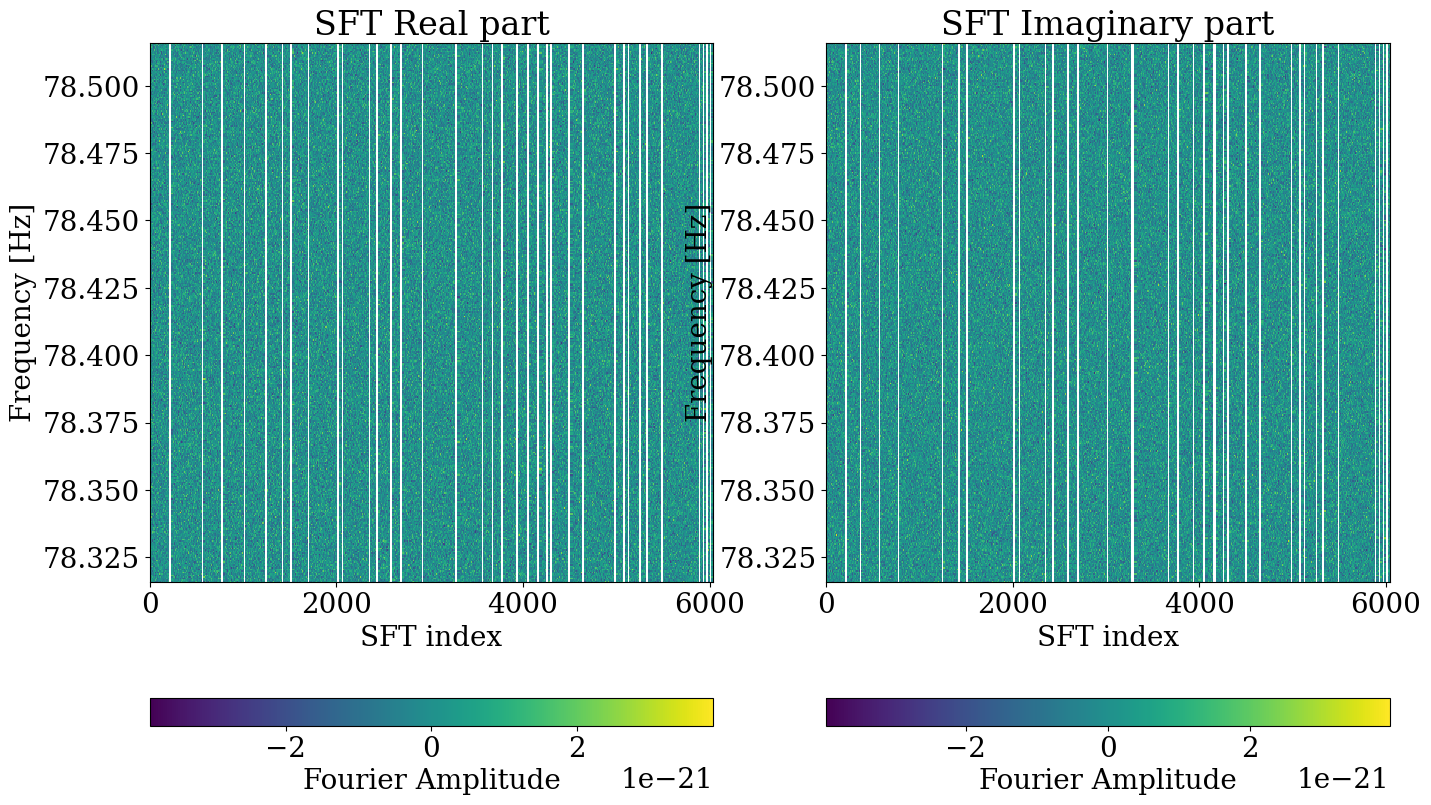

In [8]:
h_path = sorted(glob.glob(f"{OUTDIR}/*_gap.hdf5"))[0]
file_id = Path(h_path).stem

freq, h1_a, l1_a, h1_t, l1_t = load_hdf5(h_path)
print(freq.shape)
print(h1_a.shape, l1_a.shape)
print(h1_t.shape, l1_t.shape)

h1_ts_gaps = h1_t[1:] - h1_t[:-1] - 1800
print("h1 sum gap:",  round(sum(h1_ts_gaps) / (24*3600), 2) , "days")
#print(list(h1_ts_gaps))

l1_ts_gaps = l1_t[1:] - l1_t[:-1] - 1800
print("l1 sum gap:",  round(sum(l1_ts_gaps) / (24*3600), 2) , "days")
#print(list(l1_ts_gaps))

#tutorial_utils.plot_real_imag_spectrograms(h1_t, freq, h1_a)
#tutorial_utils.plot_real_imag_spectrograms(l1_t, freq, l1_a)
tutorial_utils.plot_real_imag_spectrograms_with_gaps(h1_t, freq, h1_a, 1800)
tutorial_utils.plot_real_imag_spectrograms_with_gaps(l1_t, freq, l1_a, 1800)

(360,)
(360, 5518) (360, 5518)
(5518,) (5518,)
h1 sum gap: 0.21 days
l1 sum gap: 0.21 days


(<Figure size 1600x1000 with 4 Axes>,
 array([<AxesSubplot: title={'center': 'SFT Real part'}, xlabel='SFT index', ylabel='Frequency [Hz]'>,
        <AxesSubplot: title={'center': 'SFT Imaginary part'}, xlabel='SFT index', ylabel='Frequency [Hz]'>],
       dtype=object))

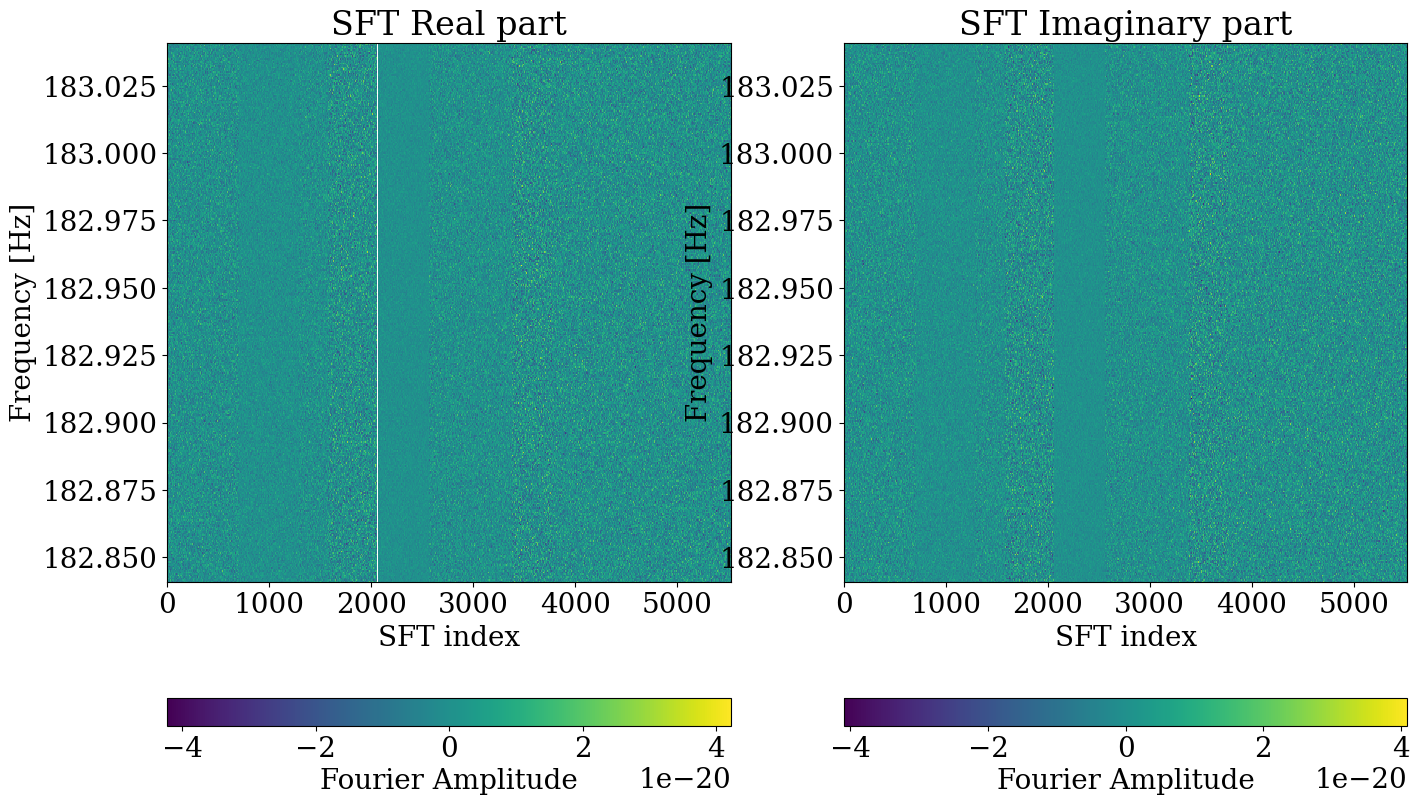

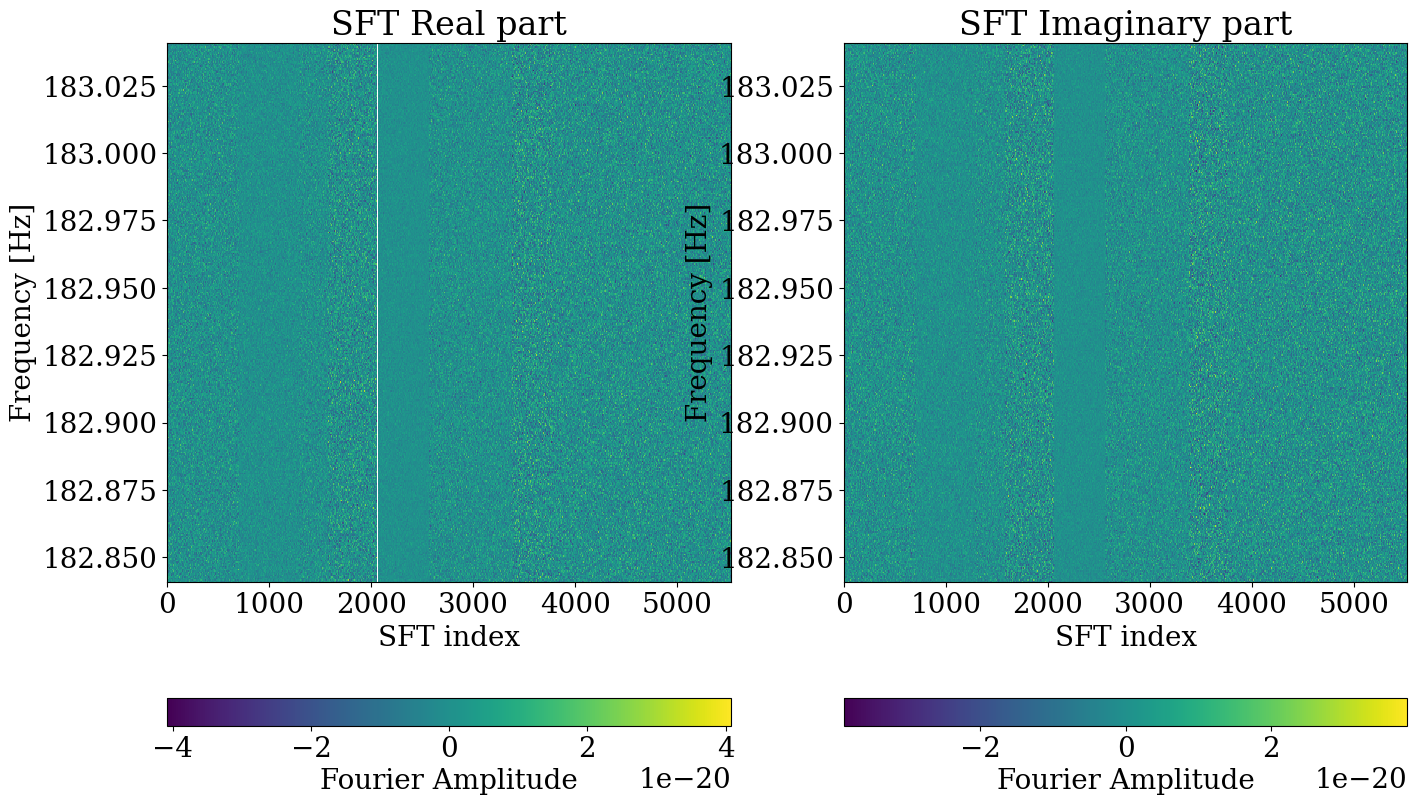

In [9]:
h_path = sorted(glob.glob(f"{OUTDIR}/*_segment*.hdf5"))[0]
file_id = Path(h_path).stem

freq, h1_a, l1_a, h1_t, l1_t = load_hdf5(h_path)
print(freq.shape)
print(h1_a.shape, l1_a.shape)
print(h1_t.shape, l1_t.shape)

h1_ts_gaps = h1_t[1:] - h1_t[:-1] - 1800
print("h1 sum gap:",  round(sum(h1_ts_gaps) / (24*3600), 2) , "days")
#print(list(h1_ts_gaps))

l1_ts_gaps = l1_t[1:] - l1_t[:-1] - 1800
print("l1 sum gap:",  round(sum(l1_ts_gaps) / (24*3600), 2) , "days")
#print(list(l1_ts_gaps))

#tutorial_utils.plot_real_imag_spectrograms(h1_t, freq, h1_a)
#tutorial_utils.plot_real_imag_spectrograms(l1_t, freq, l1_a)
tutorial_utils.plot_real_imag_spectrograms_with_gaps(h1_t, freq, h1_a, 1800)
tutorial_utils.plot_real_imag_spectrograms_with_gaps(l1_t, freq, l1_a, 1800)